# Notebook to explore Olympic Mountain Region

# Step 0 - Set up Notebook

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr 
import pyproj
import json
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import griddata
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe import get_lidar_data as lidar
from snowML.datapipe.utils import snow_types as st 
from snowML.viz import vis_utils as vu
from snowML.datapipe.utils import data_utils as du 
from snowML.LSTM import LSTM_plot3 as plot3
#from snowML.LSTM import LSTM_evaluate as evaluate
#from snowML.LSTM import LSTM_metrics as metrics

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import importlib
importlib.reload(lidar)

<module 'snowML.datapipe.get_lidar_data' from '/home/suetboyd/Capstone/SnowML/src/snowML/datapipe/get_lidar_data.py'>

# Step 1 - Get Lidar Data

In [ ]:
#files = lidar.get_files()
#len(files)

In [16]:
prefix = "USWAOL"
ds = lidar.get_lidar_all(prefix, bucket_name = None)
ds

QUEUEING TASKS | :   0%|          | 0/304 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/304 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/304 [00:00<?, ?it/s]

{'20160208': 'lidar_data/ASO_50M_SWE_USWAOL_20160208.tif', '20160329': 'lidar_data/ASO_50M_SWE_USWAOL_20160329.tif'}
Warning - have you verified the EPSG for this prefix?
Warning - have you verified the EPSG for this prefix?
The file already exists at s3://snowml-bronze/lidar_USWAOL.zarr. Skipping the save.


<xarray.Dataset> Size: 15MB
Dimensions:      (day: 2, y: 1015, x: 1792)
Coordinates:
  * day          (day) object 16B '20160208' '20160329'
  * x            (x) float64 14kB -124.2 -124.2 -124.2 ... -123.1 -123.1 -123.1
  * y            (y) float64 8kB 47.49 47.49 47.49 47.49 ... 48.09 48.09 48.09
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    SWE          (day, y, x) float32 15MB nan nan nan nan ... 8.787e-05 nan nan

In [5]:
lidar.count_na(ds)

for day All:
Number of NaN values: 62708
Percent of NaN values: 1.72%


1.723808057705841

# Step 2 - Determine which hucs are in the range 

In [6]:
import easysnowdata

In [7]:
from shapely.geometry import box

# Get min and max for x and y
x_min = ds['x'].min().item()
x_max = ds['x'].max().item()
y_min = ds['y'].min().item()
y_max = ds['y'].max().item()

# Create a bounding box (left, bottom, right, top)
bbox = box(x_min, y_min, x_max, y_max)
print(bbox)


POLYGON ((-123.12882279086489 47.49292045202944, -123.12882279086489 48.09056362513317, -124.18442330667237 48.09056362513317, -124.18442330667237 47.49292045202944, -123.12882279086489 47.49292045202944))


In [8]:
huc12_gdf = easysnowdata.hydroclimatology.get_huc_geometries(
    bbox_input=bbox, huc_level="12"
)
print(huc12_gdf.shape)
huc12_gdf.head(2)

(93, 6)


name         huc12 areasqkm states  \
0  Headwaters Wynoochee River  171001040201   106.52     WA   
1                Sitkum River  171001010401    79.97     WA   

                                    tnmid  \
0  {C2186ED7-F81A-4039-9107-FBB6D4F838C2}   
1  {61C2F7F7-8FE2-470F-8D47-A22B818477FD}   

                                            geometry  
0  POLYGON ((-123.64425 47.46938, -123.64421 47.4...  
1  POLYGON ((-124.24492 47.95474, -124.24491 47.9...

In [9]:
hucs_in_range = huc12_gdf["huc12"]


In [10]:
# Step 3 - For Each Huc In Range, Determine % Lidar Coverage 

In [11]:
nan_percents = []
for huc_id in hucs_in_range: 
    clipped_data = lidar.subset_by_huc(ds, huc_id)
    nan_percent = lidar.count_na(clipped_data, quiet = True)
    #lidar.plot_valid_pixels(clipped_data)
    nan_percents.append(nan_percent)
df_coverage = pd.DataFrame({
    "huc_id": hucs_in_range,
    "nan_percent": nan_percents
})
df_coverage = df_coverage.sort_values(by="nan_percent")
df_coverage.head()

huc_id  nan_percent
57  171100180503    21.885462
5   171001010502    26.345585
53  171100180501    28.567465
79  171100200513    29.475365
62  171100200301    30.188969

# Step 4 - Determine Snow Type of Covered Hucs 

In [12]:
# load snow_type
f = "Snow_Types_17.csv"
b = "snowml-silver"
df_static = du.s3_to_df(f, b)

In [15]:
df_static

huc_id Predominant_Snow
0     170101020101   Montane Forest
1     170101020102   Montane Forest
2     170101020103   Montane Forest
3     170101020104   Montane Forest
4     170101020105   Montane Forest
...            ...              ...
7852  171200090706        Ephemeral
7853  171200090801        Ephemeral
7854  171200090802        Ephemeral
7855  171200090803        Ephemeral
7856  171200090804        Ephemeral

[7857 rows x 2 columns]

In [16]:
# inner_join 
df_static["huc_id"] = df_static["huc_id"].astype(str)
df_coverage["huc_id"] = df_coverage["huc_id"].astype(str)
df_joined = df_static.merge(df_coverage, on="huc_id", how="inner")
df_joined.head()

huc_id Predominant_Snow  nan_percent
0  171001020101        Ephemeral    42.714252
1  171001020102        Ephemeral    51.372536
2  171001020103        Ephemeral    46.986460
3  171001020104        Ephemeral    52.287357
4  171001020105        Ephemeral    67.134999

In [19]:
counts = df_joined["Predominant_Snow"].value_counts()
counts

Predominant_Snow
Ephemeral    51
Maritime     26
Name: count, dtype: int64

In [20]:
# add color column 
def add_color_column(df, color_map_snow):
    df["color_snow_type"] = df["Predominant_Snow"].apply(lambda x: color_map_snow.get(x, "yellow"))
    return df
color_map_snow = st.color_map_standard()
df_snow = add_color_column(df_joined, color_map_snow)
df_snow.head()

huc_id Predominant_Snow  nan_percent color_snow_type
0  171001020101        Ephemeral    42.714252         #E6E6FA
1  171001020102        Ephemeral    51.372536         #E6E6FA
2  171001020103        Ephemeral    46.986460         #E6E6FA
3  171001020104        Ephemeral    52.287357         #E6E6FA
4  171001020105        Ephemeral    67.134999         #E6E6FA

In [21]:
# add geometry column 

geo_rows = []
for huc_id in df_snow["huc_id"].unique():
    gdf = gg.get_geos(huc_id, '12')  # returns a GeoDataFrame with one row
    geo_rows.append(gdf)

gdf_all = gpd.GeoDataFrame(pd.concat(geo_rows, ignore_index=True))

df_snow["huc_id"] = df_snow["huc_id"].astype(str)
gdf_all["huc_id"] = gdf_all["huc_id"].astype(str)

df_snow = pd.merge(df_snow, gdf_all[["huc_id", "geometry"]], on="huc_id", how="left")

gdf_snow = gpd.GeoDataFrame(df_snow, geometry="geometry")

gdf_snow.set_crs("EPSG:4326", inplace=True)

gdf_snow.head()


huc_id Predominant_Snow  nan_percent color_snow_type  \
0  171001020101        Ephemeral    42.714252         #E6E6FA   
1  171001020102        Ephemeral    51.372536         #E6E6FA   
2  171001020103        Ephemeral    46.986460         #E6E6FA   
3  171001020104        Ephemeral    52.287357         #E6E6FA   
4  171001020105        Ephemeral    67.134999         #E6E6FA   

                                            geometry  
0  POLYGON ((-123.89846 47.73129, -123.89845 47.7...  
1  POLYGON ((-123.9043 47.71646, -123.90442 47.71...  
2  POLYGON ((-124.10771 47.68974, -124.10786 47.6...  
3  POLYGON ((-124.13172 47.77801, -124.13221 47.7...  
4  POLYGON ((-124.18095 47.65484, -124.18093 47.6...

In [41]:
#gdf_snow.explore(color=gdf_snow["color_snow_type"], legend=True)
m = gdf_snow.explore(color=gdf_snow["color_snow_type"], legend=True)
gdf_box = gpd.GeoDataFrame(geometry=[bbox], crs=gdf_snow.crs)
gdf_box.explore(m=m, color="black", fill=False, linewidth=2)

In [42]:
# Step 5 - Narrow to just Hucs with Maritime Snow 
gdf_snow_mar = gdf_snow[gdf_snow["Predominant_Snow"] == "Maritime"]
gdf_snow_mar.head()

huc_id Predominant_Snow  nan_percent color_snow_type  \
5   171001020201         Maritime    48.603122            blue   
16  171001020401         Maritime    54.176087            blue   
17  171001020402         Maritime    53.694018            blue   
19  171001020404         Maritime    54.579217            blue   
20  171001020405         Maritime    53.968157            blue   

                                             geometry  
5   POLYGON ((-123.61837 47.79886, -123.61863 47.7...  
16  POLYGON ((-123.33162 47.72121, -123.33185 47.7...  
17  POLYGON ((-123.47129 47.57861, -123.47154 47.5...  
19  POLYGON ((-123.47485 47.68477, -123.4749 47.68...  
20  POLYGON ((-123.59391 47.73981, -123.59421 47.7...

In [51]:
# Based on map, exclude the following maritime hucs as not totally w/in bounds
exclude_ls = ['171100180202', '171100180601', '171100180602', '171100200301']

In [49]:
huc_olympic_mar = list(gdf_snow_mar["huc_id"])
len(huc_olympic_mar)

26

In [53]:
huc_olympic_mar_final = [huc for huc in huc_olympic_mar if huc not in exclude_ls]
print(len(huc_olympic_mar_final))
huc_olympic_mar_final

22


['171001020201',
 '171001020401',
 '171001020402',
 '171001020404',
 '171001020405',
 '171100170201',
 '171100180401',
 '171100180501',
 '171100180502',
 '171100200303',
 '171100200304',
 '171100200305',
 '171100200501',
 '171100200502',
 '171100200503',
 '171100200504',
 '171100200506',
 '171100200507',
 '171100200508',
 '171100200509',
 '171100200510',
 '171100210201']

For huc 171001020201
for day All:
Number of NaN values: 87194
Percent of NaN values: 48.60%


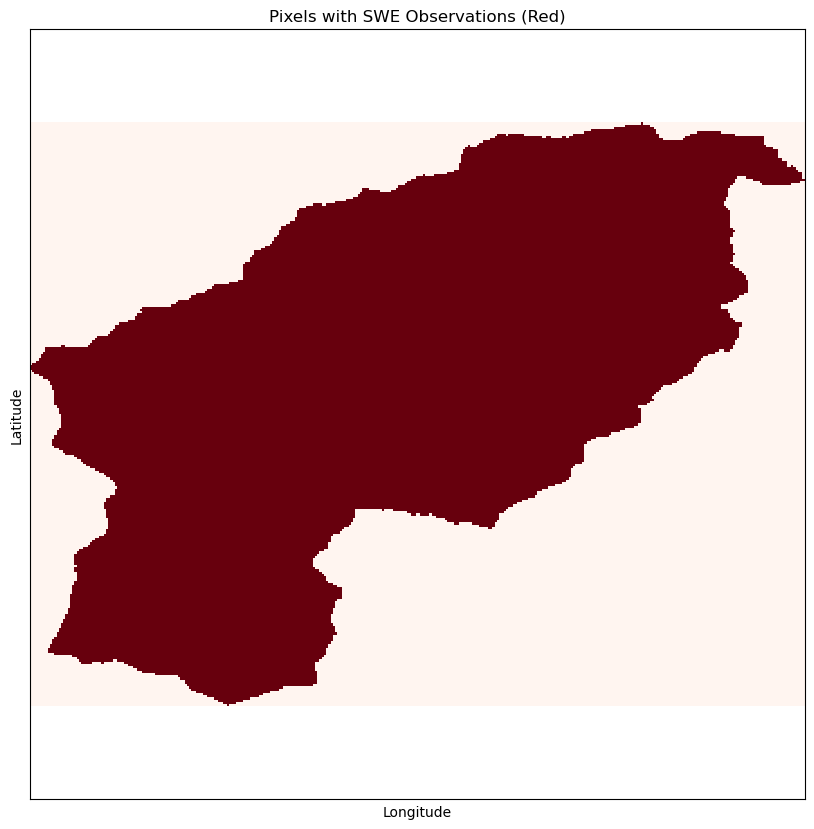

For huc 171001020401
for day All:
Number of NaN values: 80510
Percent of NaN values: 54.18%


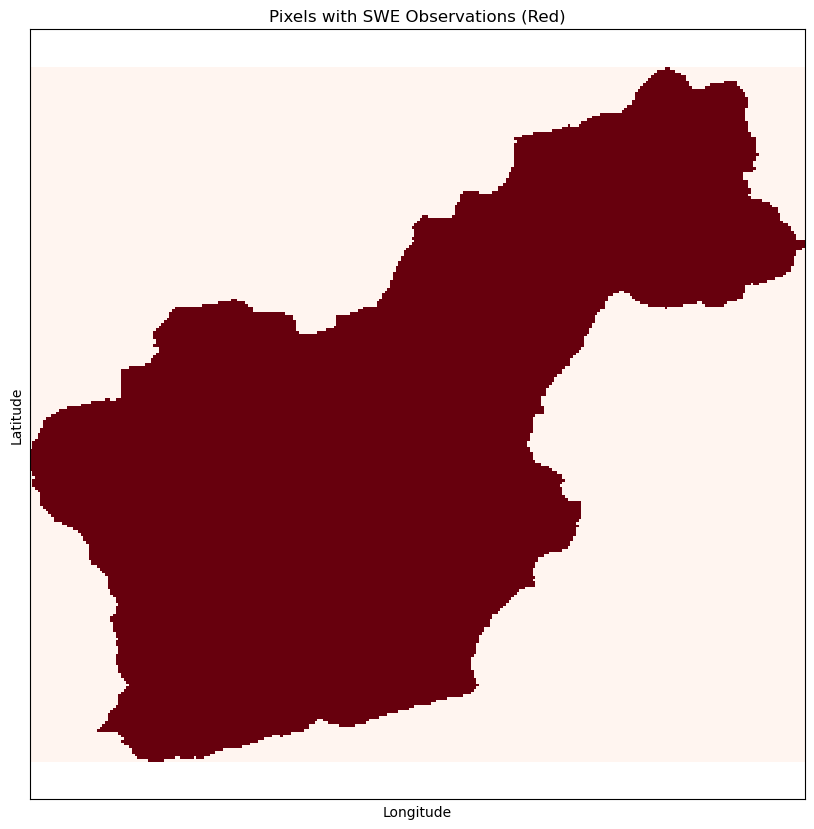

For huc 171001020402
for day All:
Number of NaN values: 39420
Percent of NaN values: 53.69%


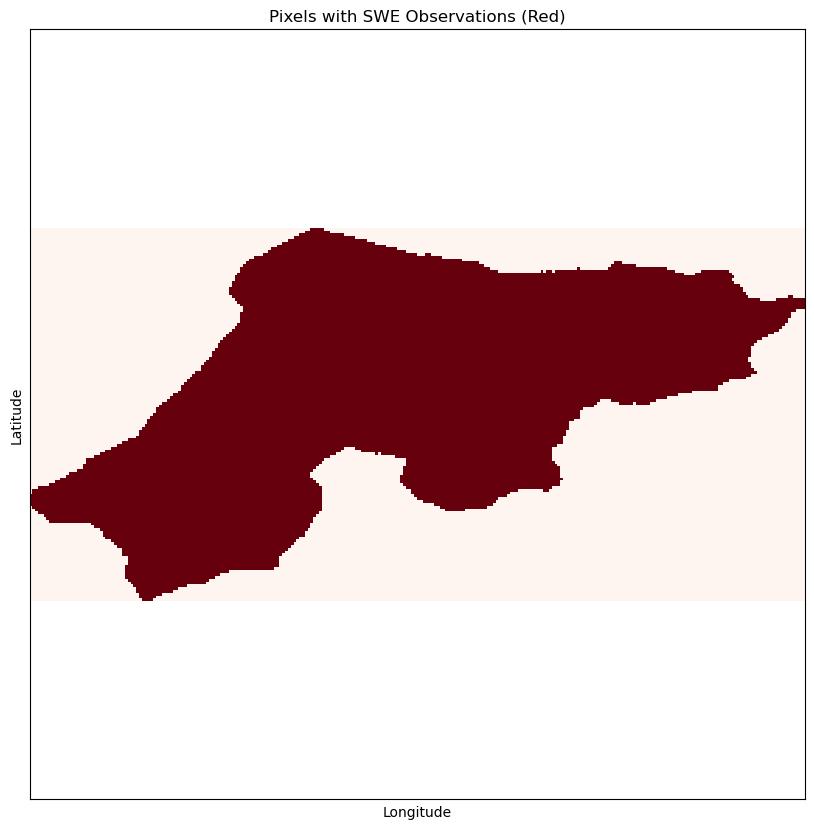

For huc 171001020404
for day All:
Number of NaN values: 45852
Percent of NaN values: 54.58%


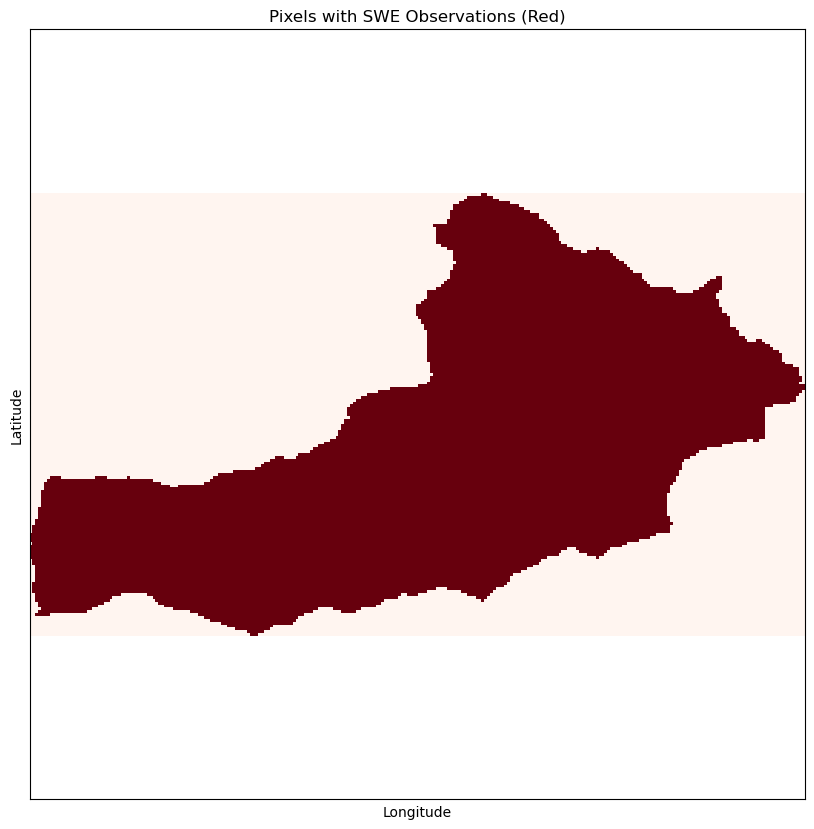

For huc 171001020405
for day All:
Number of NaN values: 123654
Percent of NaN values: 53.97%


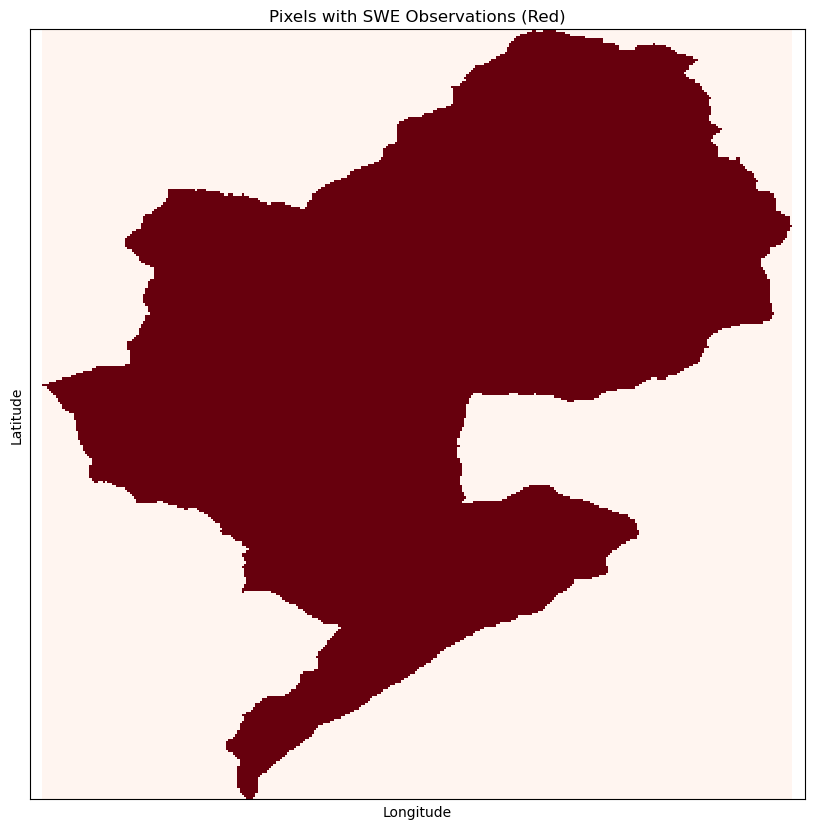

For huc 171100170201
for day All:
Number of NaN values: 113566
Percent of NaN values: 57.15%


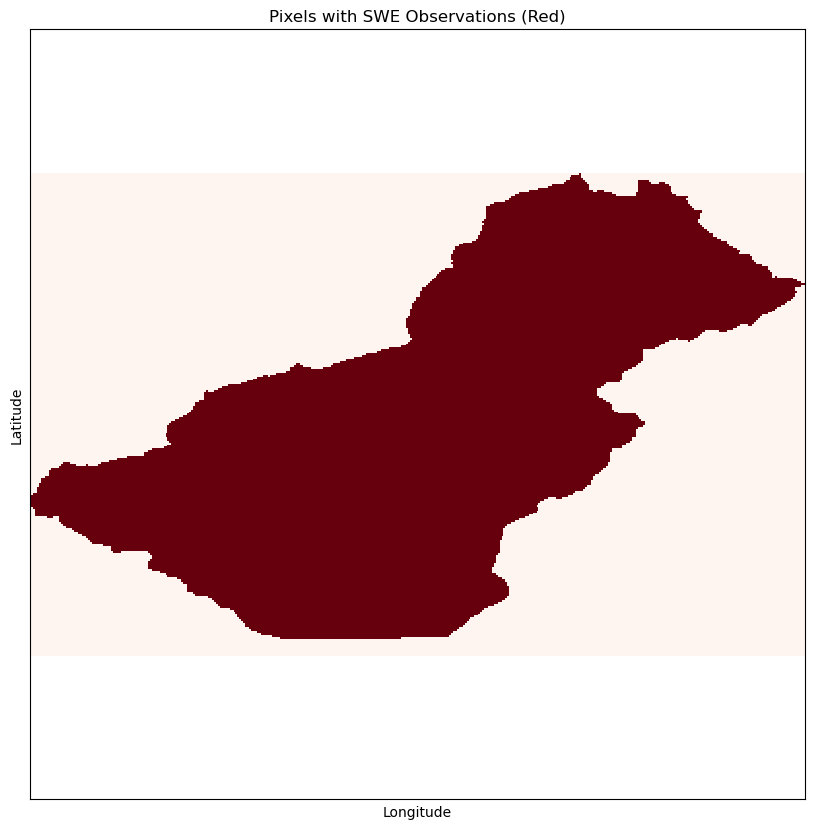

For huc 171100180202
for day All:
Number of NaN values: 86732
Percent of NaN values: 54.41%


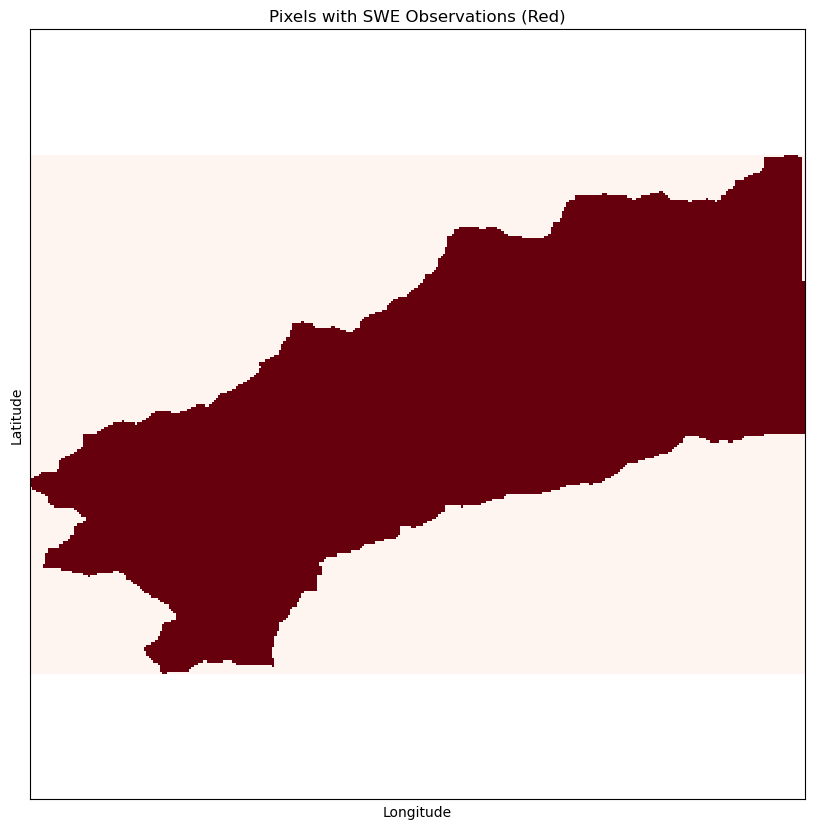

For huc 171100180401
for day All:
Number of NaN values: 73484
Percent of NaN values: 47.32%


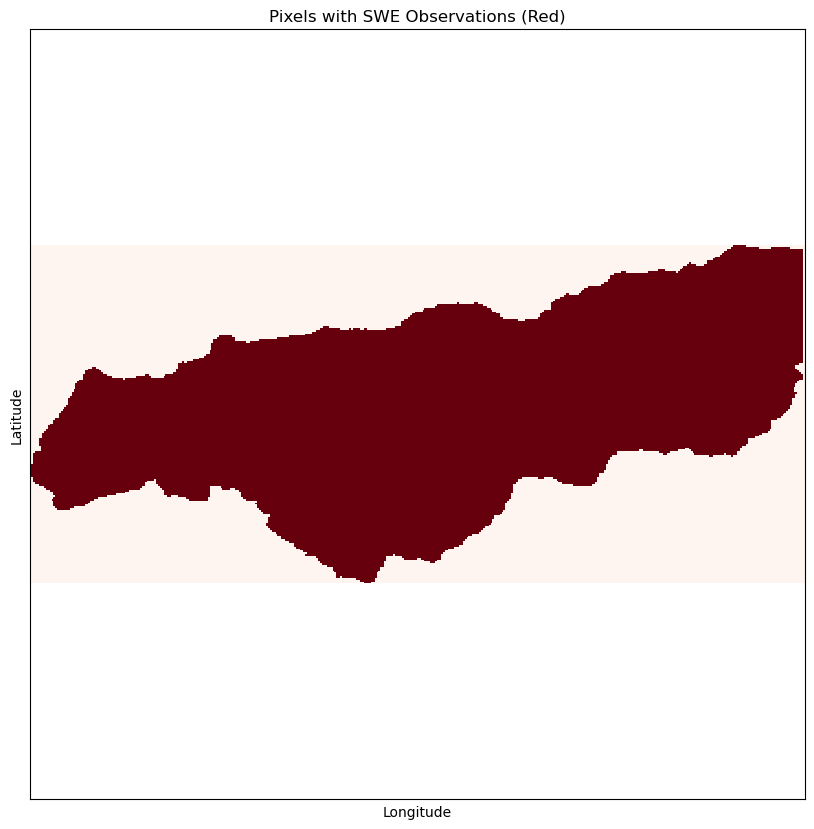

For huc 171100180501
for day All:
Number of NaN values: 14414
Percent of NaN values: 28.57%


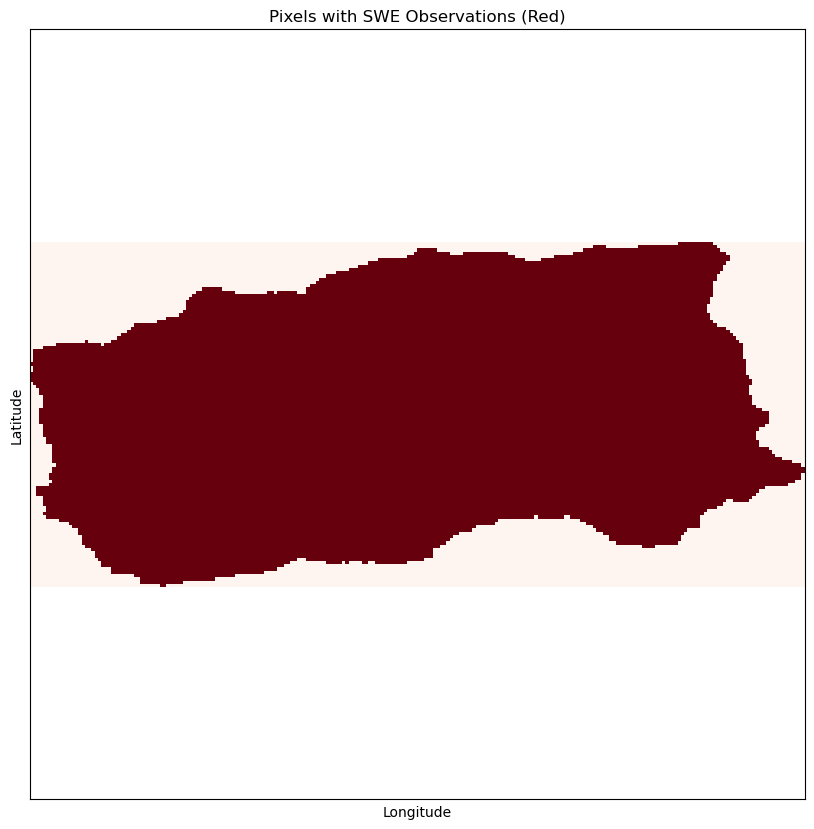

For huc 171100180502
for day All:
Number of NaN values: 35124
Percent of NaN values: 33.03%


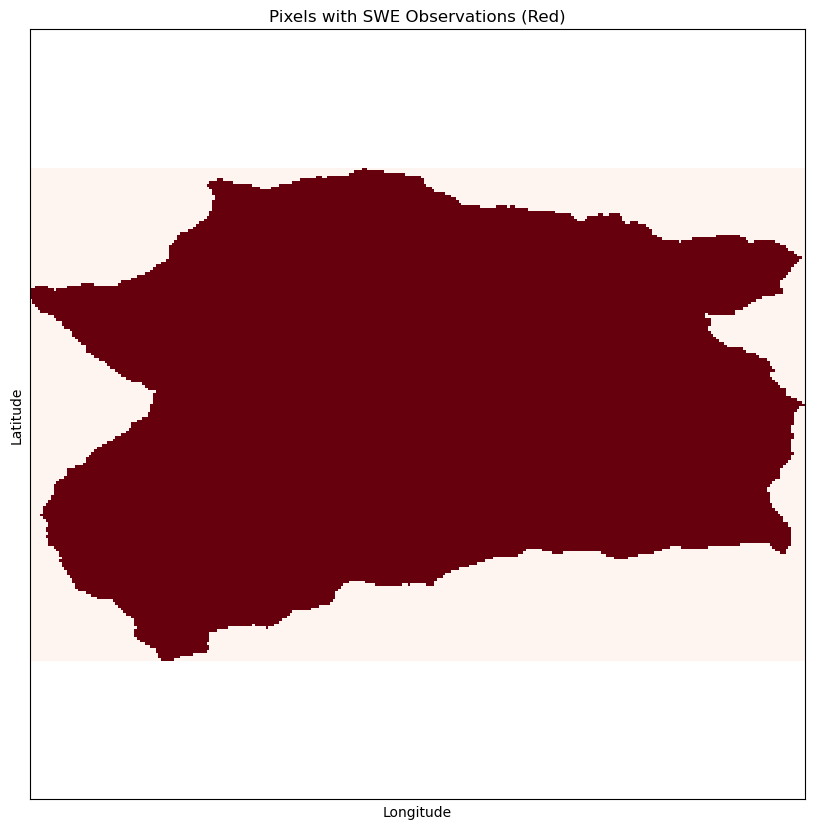

For huc 171100180601
for day All:
Number of NaN values: 1734
Percent of NaN values: 54.12%


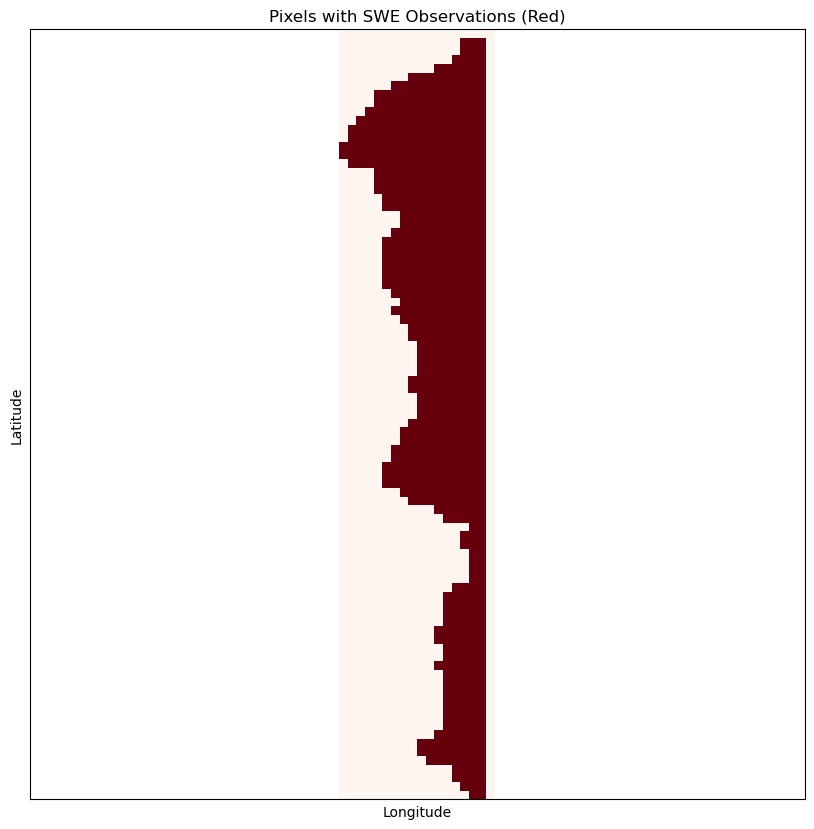

For huc 171100180602
for day All:
Number of NaN values: 364
Percent of NaN values: 41.94%


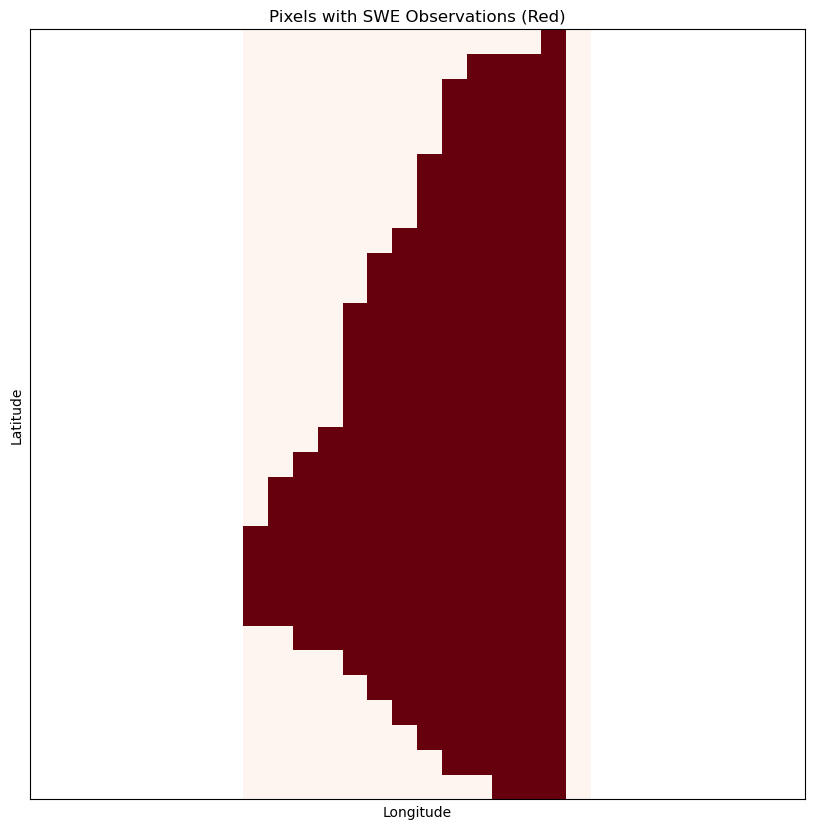

For huc 171100200301
for day All:
Number of NaN values: 27478
Percent of NaN values: 30.19%


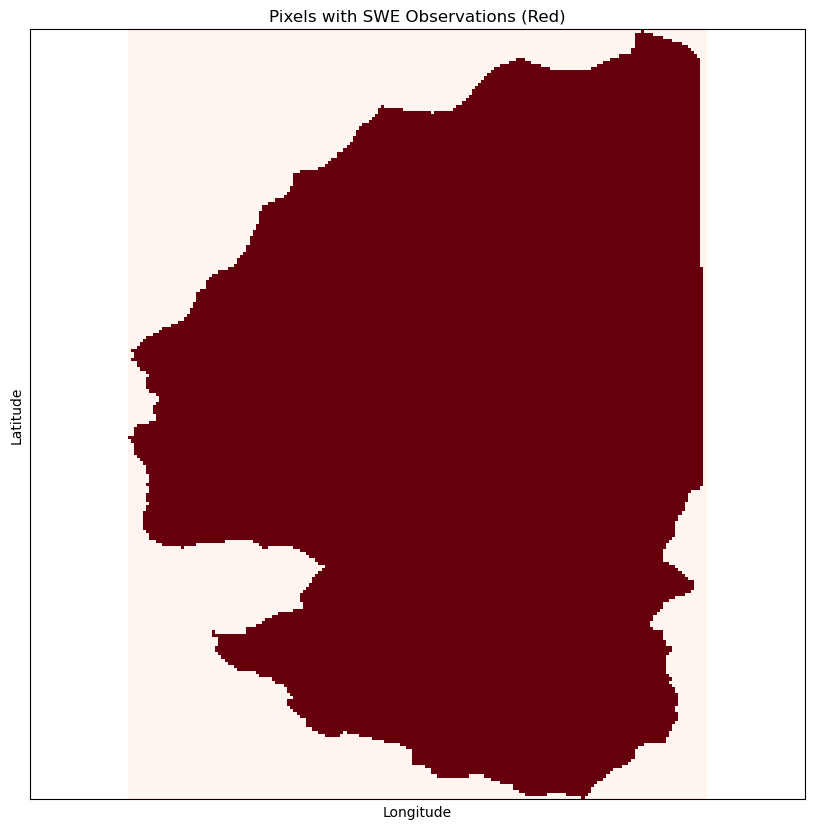

For huc 171100200303
for day All:
Number of NaN values: 43846
Percent of NaN values: 42.24%


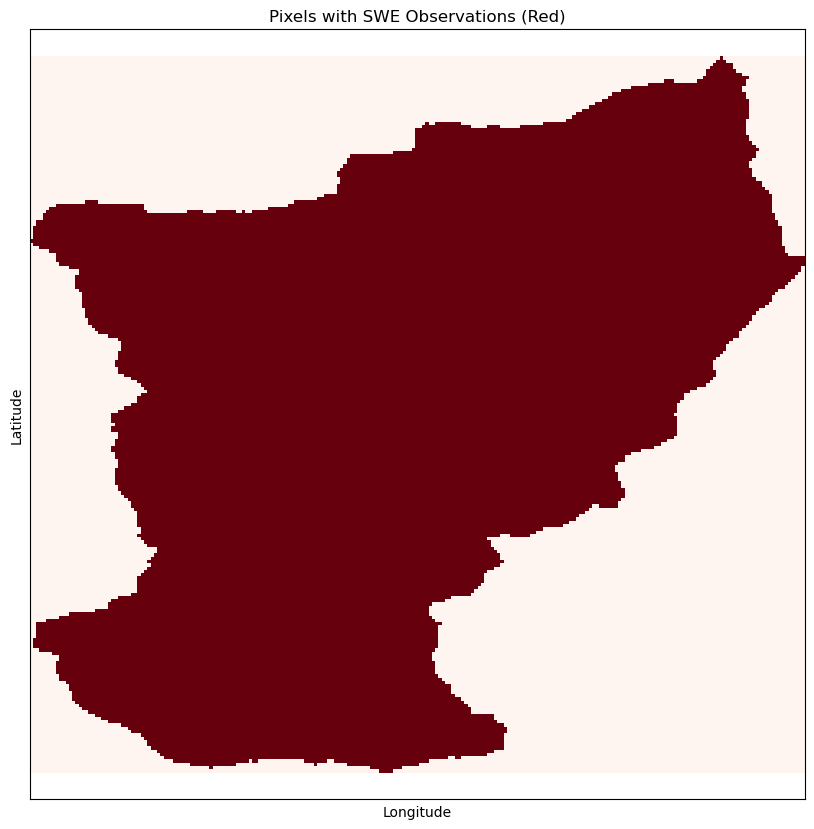

For huc 171100200304
for day All:
Number of NaN values: 28680
Percent of NaN values: 47.12%


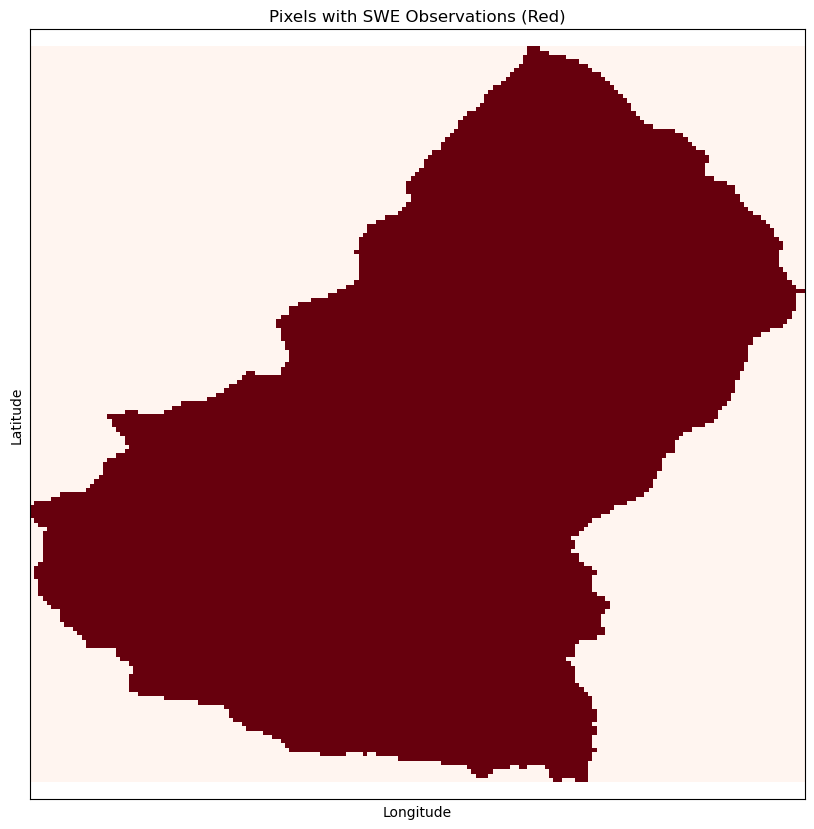

For huc 171100200305
for day All:
Number of NaN values: 28694
Percent of NaN values: 41.58%


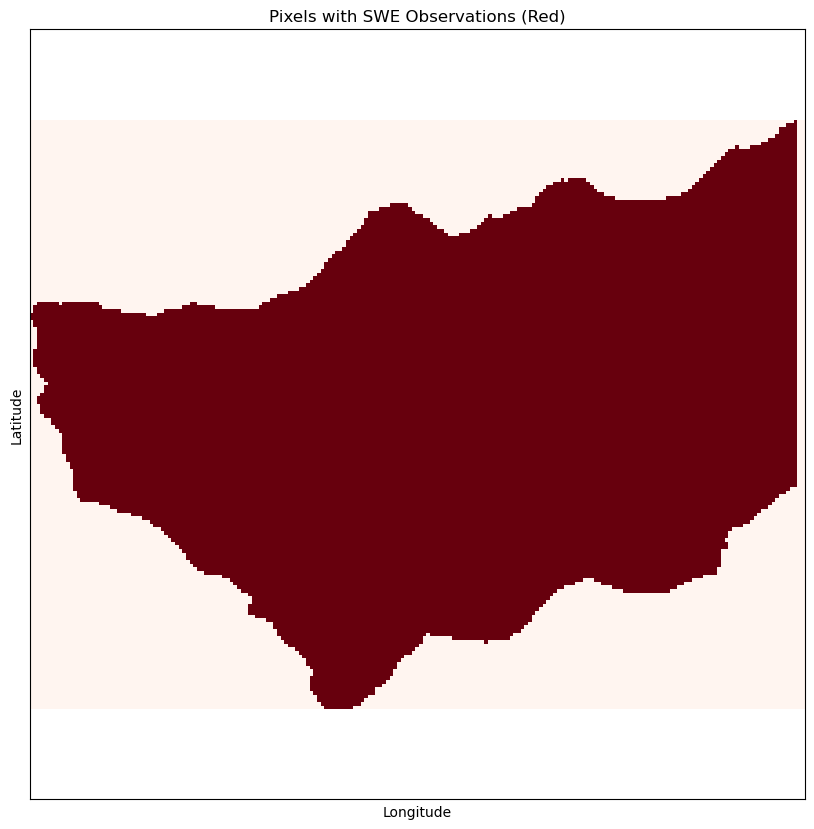

For huc 171100200501
for day All:
Number of NaN values: 38146
Percent of NaN values: 44.49%


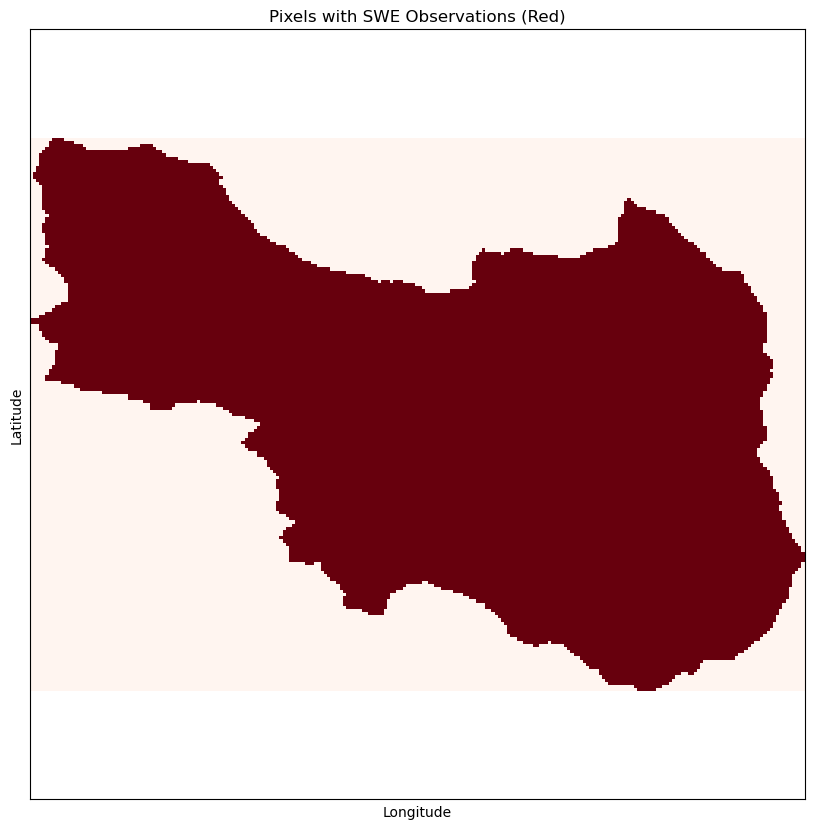

For huc 171100200502
for day All:
Number of NaN values: 20484
Percent of NaN values: 38.79%


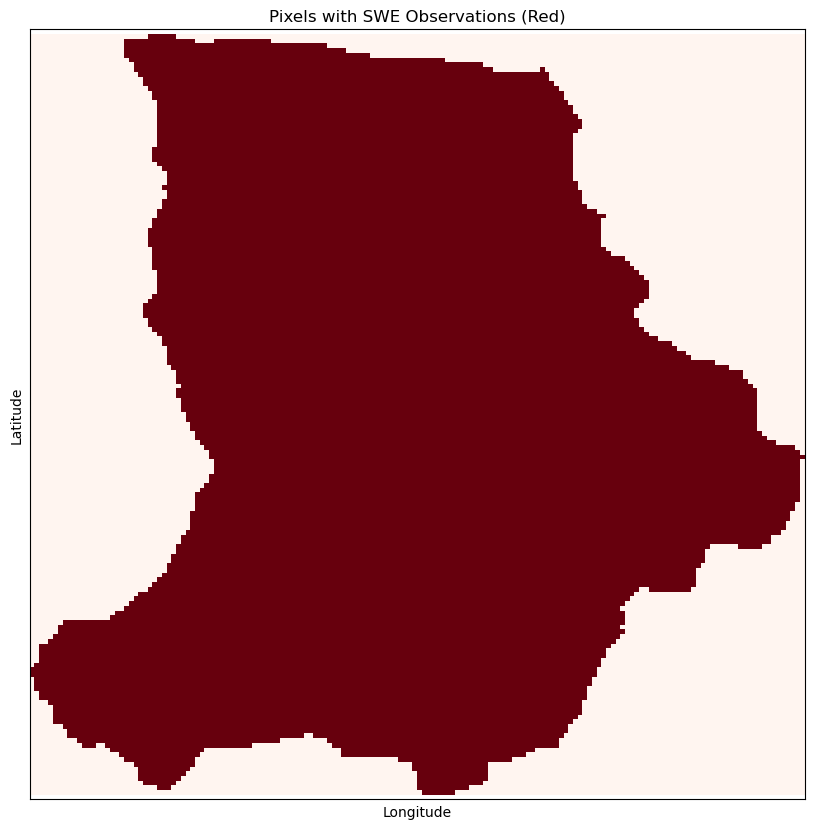

For huc 171100200503
for day All:
Number of NaN values: 38472
Percent of NaN values: 53.57%


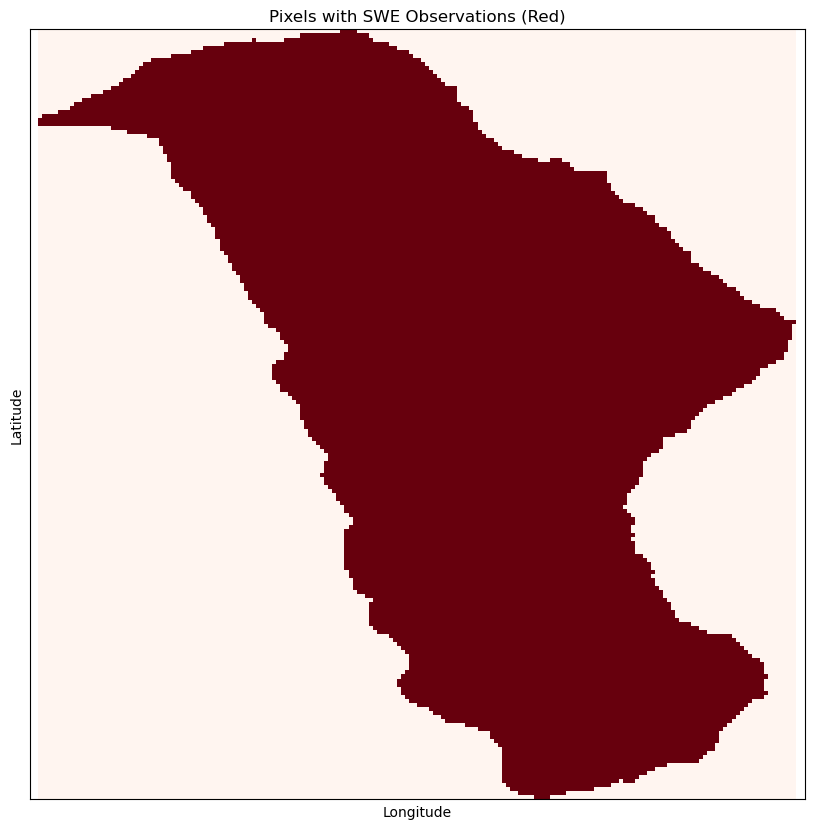

For huc 171100200504
for day All:
Number of NaN values: 30360
Percent of NaN values: 37.58%


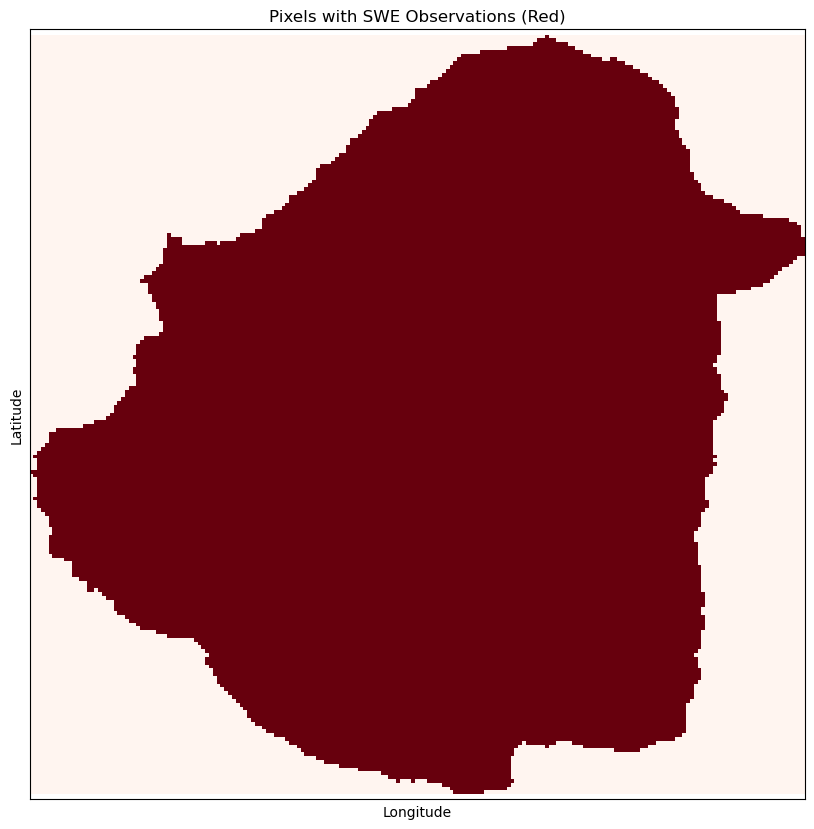

For huc 171100200506
for day All:
Number of NaN values: 75378
Percent of NaN values: 62.78%


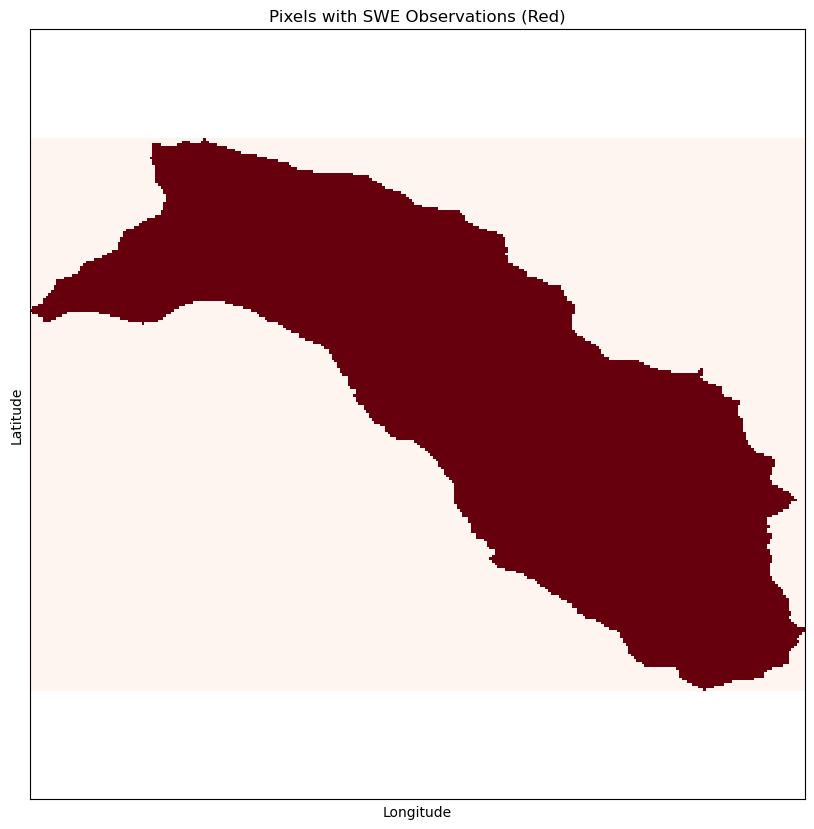

For huc 171100200507
for day All:
Number of NaN values: 41904
Percent of NaN values: 47.53%


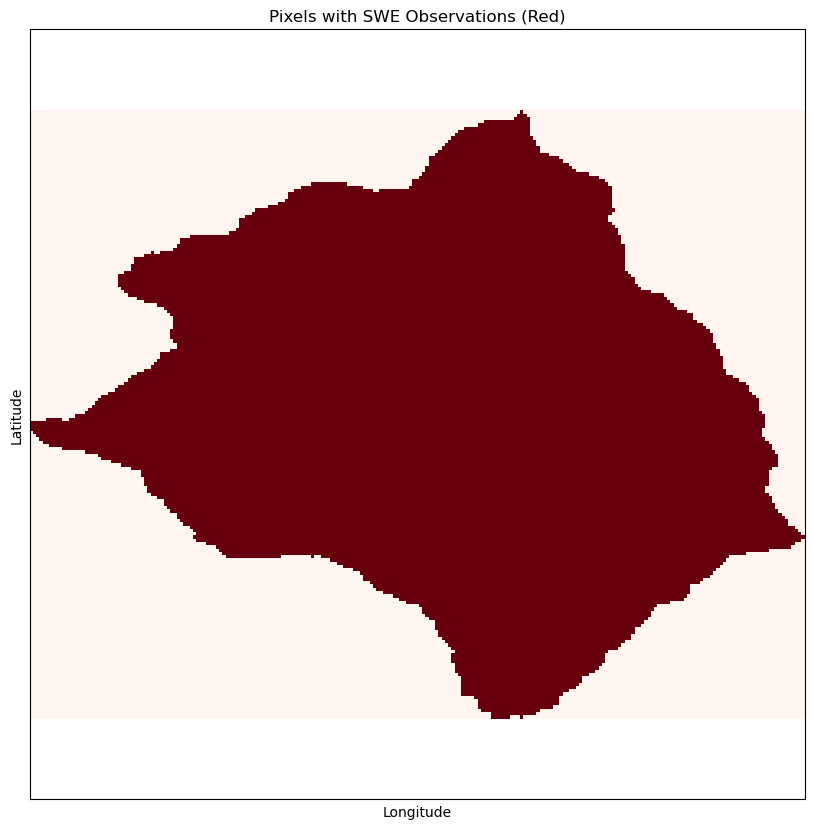

For huc 171100200508
for day All:
Number of NaN values: 77864
Percent of NaN values: 62.60%


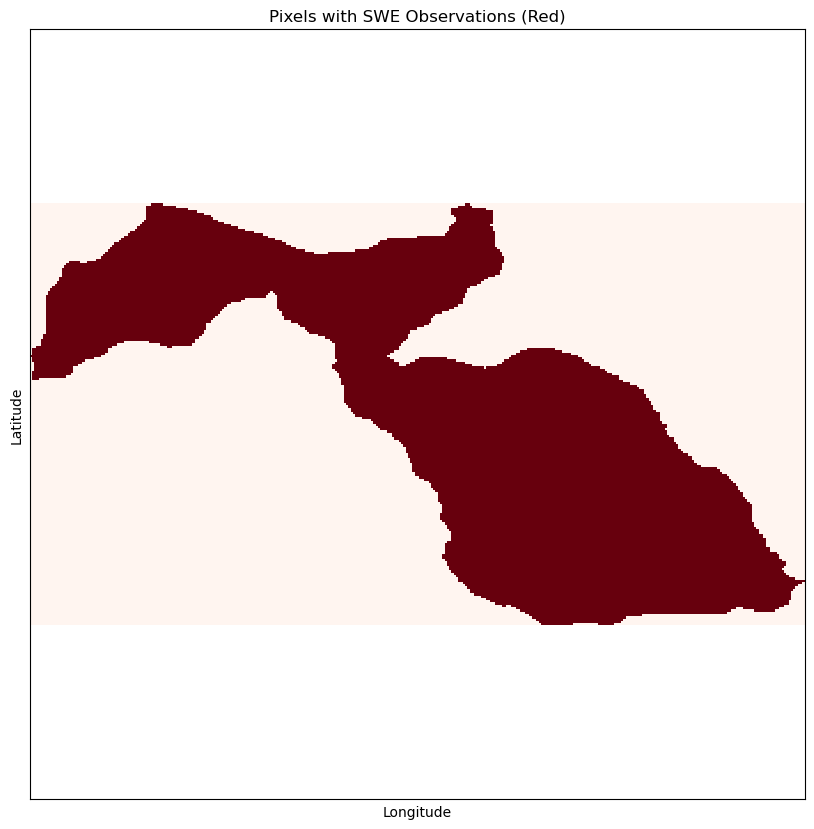

For huc 171100200509
for day All:
Number of NaN values: 31080
Percent of NaN values: 45.28%


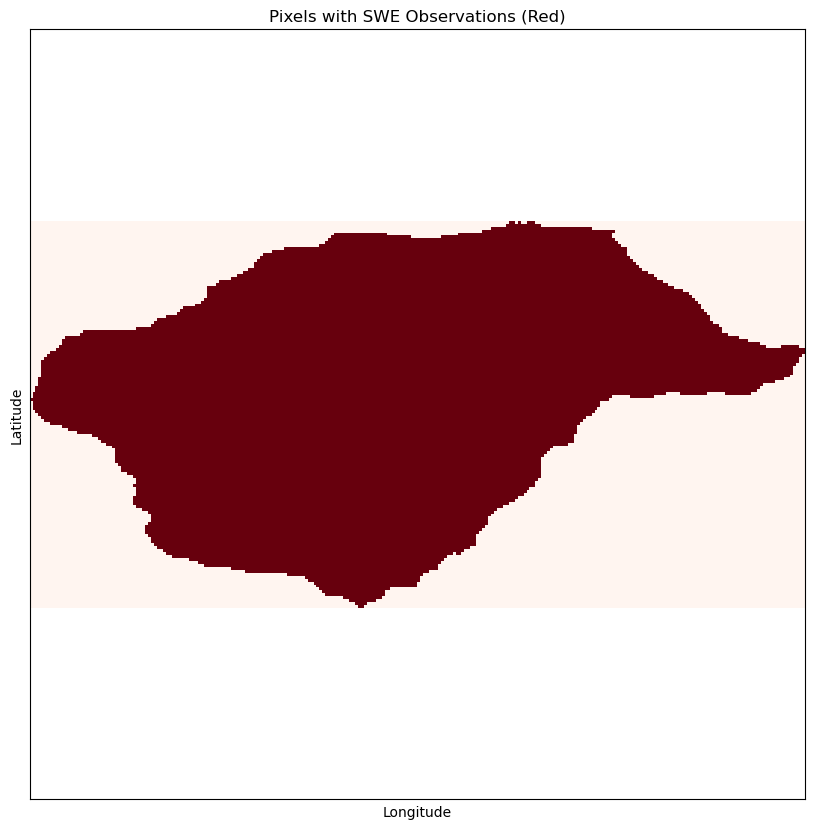

For huc 171100200510
for day All:
Number of NaN values: 95972
Percent of NaN values: 67.02%


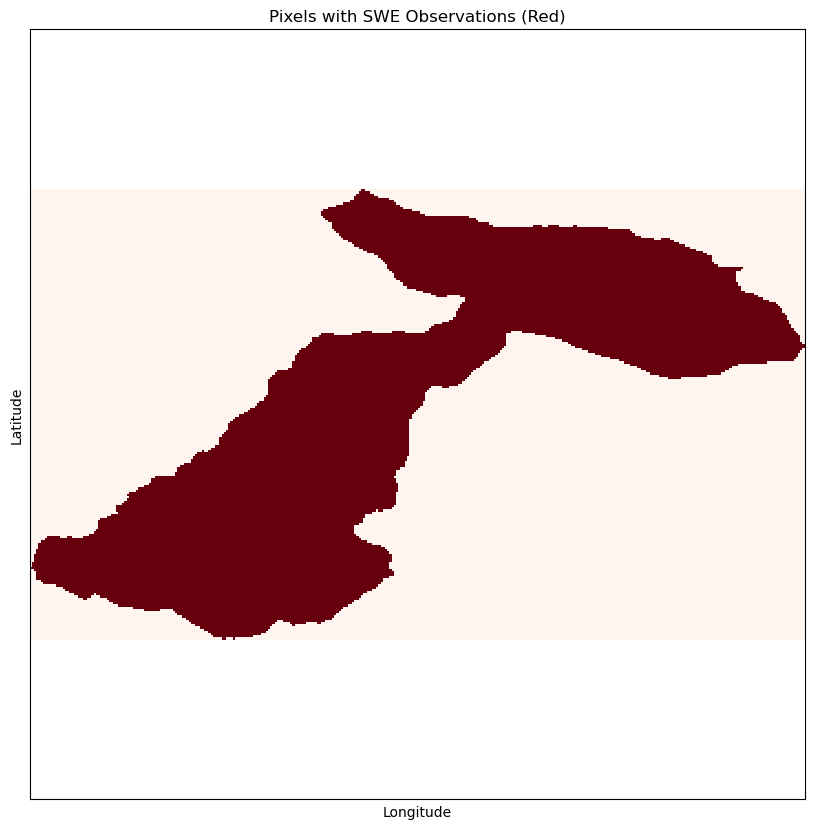

For huc 171100210201
for day All:
Number of NaN values: 19008
Percent of NaN values: 40.20%


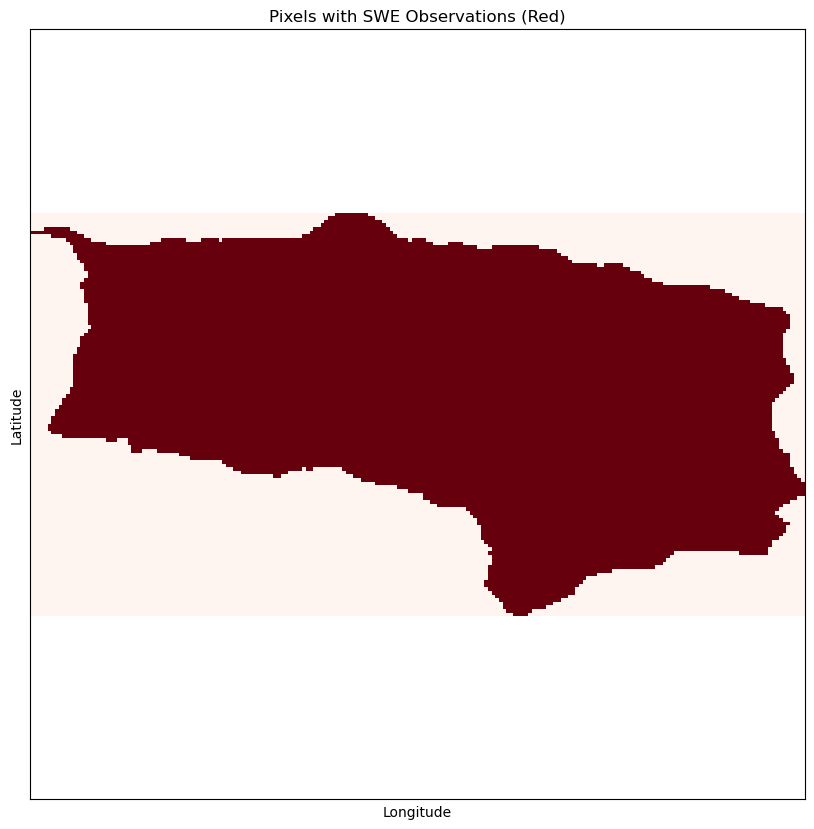

In [39]:
for huc in huc_olympic_mar_final: 
    print(f"For huc {huc}")
    clipped_data = lidar.subset_by_huc(ds, huc)
    nan_percent = lidar.count_na(clipped_data)
    lidar.plot_valid_pixels(clipped_data)